# Activation Patching by attention layers, mlps, and every token

In [1]:
from nnsight import LanguageModel
import torch
torch.set_grad_enabled(False)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import string
import os

In [2]:
llm = LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto", torch_dtype=torch.float32)

In [3]:
N_LAYERS = llm.model.config.num_hidden_layers
N_HEADS = llm.model.config.num_attention_heads
hidden_size = llm.model.layers[0].self_attn.q_proj.weight.shape[0]
HEAD_SIZE = hidden_size // N_HEADS

In [4]:
def run_activation_patching(prompts, answer_token_indices):  
    patching_results = {layer: {"attn": {}, "mlp": {}} for layer in range(N_LAYERS)}  # Pre-allocate layer keys
    z_l = {}

    # Clean run, grab clean activations for layer
    with llm.trace(prompts[0]):
        clean_tokens = llm.inputs[1]["input_ids"][0].save()
        for layer in range(N_LAYERS):
            z_l[layer] = {
                "attn": llm.model.layers[layer].self_attn.output.save(),
                "mlp": llm.model.layers[layer].mlp.output.save()
            }
        # Get logits from lm_head
        clean_logits = llm.lm_head.output
        clean_logit_difference = (clean_logits[0, -1, answer_token_indices[0][0]] - clean_logits[0, -1, answer_token_indices[0][1]]).save()

    # Corrupted run, grab the corrupted logits for later comparison    
    with llm.trace(prompts[1]):
        corrupted_logits = llm.lm_head.output
        corrupted_logit_difference = (corrupted_logits[0, -1, answer_token_indices[0][0]] - corrupted_logits[0, -1, answer_token_indices[0][1]]).save()
    
    print(clean_tokens)

    # Patching
    # Start with the activation patching. We take the average of the clean and reversed activations and use the first prompt set for patching: iterate through all the layers
    for layer in range(N_LAYERS):
        for token_idx in range(len(clean_tokens)):  
            with llm.trace(prompts[1]):
                # Activation patching MLP
                # mlp_output = llm.model.layers[layer].mlp.output.save() # for testing
                llm.model.layers[layer].mlp.output[:, token_idx, :] = z_l[layer]["mlp"][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["mlp"][f"token_{token_idx}"] = patched_result.item().save() 

            with llm.trace(prompts[1]):
                # Activation patching attention
                # self_attn_output = llm.model.layers[layer].self_attn.output.save() # for testing
                llm.model.layers[layer].self_attn.output[0][:, token_idx, :] = z_l[layer]["attn"][0][:, token_idx, :]
                patched_logits = llm.lm_head.output
                patched_logit_difference = (patched_logits[0, -1, answer_token_indices[0][0]] - patched_logits[0, -1, answer_token_indices[0][1]]).save()
                patched_result = (patched_logit_difference - corrupted_logit_difference) / (clean_logit_difference - corrupted_logit_difference)
                patching_results[layer]["attn"][f"token_{token_idx}"] = patched_result.item().save() 

    patching_results = {
        "clean_run_logit_difference": clean_logit_difference,
        "corrupted_run_logit_difference": corrupted_logit_difference,
        "patching_results": patching_results    
    }

    return patching_results, clean_tokens 

In [5]:
def plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, corrupted_tokens, prompt_row, answers):
    # Plotting: Two heatmaps side by side with Attention and MLP interleaved on Y-axis
    N_LAYERS = len(patching_results["patching_results"])
    seq_len = len(clean_tokens)
    seq_len_corrupted = len(corrupted_tokens)

    # Extract data for attention and MLP for both patching_results and patching_results_reversed
    combined_effects = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results
    combined_effects_reversed = np.zeros((N_LAYERS * 2, seq_len))  # For patching_results_reversed

    # Process patching_results
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    # Process patching_results_reversed
    for layer in range(N_LAYERS):
        for token_idx in range(seq_len):
            attn_effect = float(patching_results_reversed["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed[layer * 2, token_idx] = attn_effect      # Attention row
            combined_effects_reversed[layer * 2 + 1, token_idx] = mlp_effect  # MLP row

    clean_diff = float(patching_results["clean_run_logit_difference"].item())
    corrupted_diff = float(patching_results["corrupted_run_logit_difference"].item())
    clean_diff_reversed = float(patching_results_reversed["clean_run_logit_difference"].item())
    corrupted_diff_reversed = float(patching_results_reversed["corrupted_run_logit_difference"].item())

    # Create the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

    # Heatmap 1: patching_results
    im1 = ax1.imshow(combined_effects, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax1.set_title('Example 1, Order 1', fontsize=14)

    # X-axis: Token labels for the first subplot
    token_labels = [llm.tokenizer.decode([tok]) for tok in clean_tokens]
    ax1.set_xticks(np.arange(seq_len))
    ax1.set_xticklabels(token_labels, fontsize=10, rotation=45, ha='right')

    # Y-axis: Interleave Attention and MLP labels for each layer (shared)
    y_labels = []
    for layer in range(N_LAYERS):
        y_labels.extend([f'Attn {layer}', f'MLP {layer}'])
    ax1.set_yticks(np.arange(N_LAYERS * 2))
    ax1.set_yticklabels(y_labels, fontsize=10)

    # Add grid lines to the first subplot, aligned with cell boundaries using minor ticks
    ax1.set_xticks(np.arange(seq_len + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax1.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Heatmap 2: patching_results_reversed
    token_labels_corrupted = [llm.tokenizer.decode([tok]) for tok in corrupted_tokens]
    im2 = ax2.imshow(combined_effects_reversed, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
    ax2.set_title('Patching Effects (Reversed Order)', fontsize=14)

    # X-axis: Token labels for the second subplot
    ax2.set_xticks(np.arange(seq_len_corrupted))
    ax2.set_xticklabels(token_labels_corrupted, fontsize=10, rotation=45, ha='right')

    # Add grid lines to the second subplot, aligned with cell boundaries using minor ticks
    ax2.set_xticks(np.arange(seq_len_corrupted + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid
    ax2.set_yticks(np.arange(N_LAYERS * 2 + 1) - 0.5, minor=True)  # Minor ticks at boundaries for grid (shared with ax1)
    ax2.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add a shared colorbar, moved further to the right
    cbar = fig.colorbar(im2, ax=[ax1, ax2], label='Normalized Patching Effect', fraction=0.02, pad=0.1)

    # Add overall title and clean/corrupted context
    fig.suptitle(f'Patching Effects by Layer and Token\n(Clean: "{answers[0][0]}" vs Corrupted: "{answers[0][1]}")', fontsize=16, y=0.98)
    fig.text(0.5, 0.02, 
             f'Original Order: Clean Logit Diff: {clean_diff:.3f} | Corrupted Logit Diff: {corrupted_diff:.3f}\n'
             f'Reversed Order: Clean Logit Diff: {clean_diff_reversed:.3f} | Corrupted Logit Diff: {corrupted_diff_reversed:.3f}', 
             fontsize=11, ha='center')

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15, right=0.85)  # Adjust right to make space for the colorbar

    # Save and show
    plt.savefig(f'patching_effects_heatmap_combined_{prompt_row}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [24]:
def plot_2x2_heatmaps(patching_results1, patching_results2, patching_results_reversed1, patching_results_reversed2, clean_tokens, clean_tokens_reversed, clean_tokens_2, clean_tokens_reversed_2, prompt_row):
    """
    Create a 2x2 grid of heatmaps showing patching effects for two examples in two different orders.
    
    Args:
        patching_results1: Patching results for first example, first order
        patching_results2: Patching results for second example, first order
        patching_results_reversed1: Patching results for first example, reversed order
        patching_results_reversed2: Patching results for second example, reversed order
        clean_tokens: Tokens for first example, first order
        clean_tokens_reversed: Tokens for first example, reversed order
        clean_tokens_2: Tokens for second example, first order
        clean_tokens_reversed_2: Tokens for second example, reversed order
        prompt_row: Row index for saving the figure
    """
    # Set up figure parameters
    FIGWIDTH = 6.5  # Increased figure width for more space
    SIZE = 6
    
    # Configure matplotlib settings
    setup_matplotlib_params(SIZE)
    
    # Extract and process patching data
    N_LAYERS = len(patching_results1["patching_results"])
    seq_len = len(clean_tokens)
    seq_len_2 = len(clean_tokens_2)

    # Process all patching results into combined effects matrices
    combined_effects = process_patching_results(
        patching_results1, patching_results2, 
        patching_results_reversed1, patching_results_reversed2,
        N_LAYERS, seq_len, seq_len_2
    )
    
    # Create and configure the figure
    fig, axes = plt.subplots(2, 2, figsize=(FIGWIDTH, FIGWIDTH))
    
    # Organize data for plotting
    data = combined_effects
    titles = ["Example 1, Order 1", "Example 1, Order 2", "Example 2, Order 1", "Example 2, Order 2"]
    tokens = [clean_tokens, clean_tokens_reversed, clean_tokens_2, clean_tokens_reversed_2]
    
    # Create each heatmap
    im = create_heatmaps(axes, data, titles, tokens, N_LAYERS, SIZE)
    
    # Add colorbar and finalize layout
    add_colorbar_and_finalize(fig, im, axes, SIZE, prompt_row)


def setup_matplotlib_params(size):
    """Configure matplotlib parameters for consistent styling"""
    plt.rc("font", size=size)
    plt.rc("axes", titlesize=size)
    plt.rc("xtick", labelsize=size)
    plt.rc("ytick", labelsize=size)
    plt.rc("legend", fontsize=size)
    
    mpl.rcParams["figure.dpi"] = 300
    mpl.rcParams["savefig.dpi"] = 300


def process_patching_results(patching_results1, patching_results2, patching_results_reversed1, patching_results_reversed2, n_layers, seq_len, seq_len_2):
    """Process patching results into matrices for visualization"""
    # Initialize matrices to hold combined effects
    combined_effects1 = np.zeros((n_layers * 2, seq_len))  
    combined_effects2 = np.zeros((n_layers * 2, seq_len_2))
    combined_effects_reversed1 = np.zeros((n_layers * 2, seq_len))
    combined_effects_reversed2 = np.zeros((n_layers * 2, seq_len_2))

    # Extract values from patching results
    for layer in range(n_layers):
        for token_idx in range(seq_len):
            # First example, first order
            attn_effect = float(patching_results1["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results1["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects1[layer * 2, token_idx] = attn_effect
            combined_effects1[layer * 2 + 1, token_idx] = mlp_effect
            
            # First example, reversed order
            attn_effect = float(patching_results_reversed1["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed1["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed1[layer * 2, token_idx] = attn_effect
            combined_effects_reversed1[layer * 2 + 1, token_idx] = mlp_effect
            
    for layer in range(n_layers):
        for token_idx in range(seq_len_2):
            # Second example, first order
            attn_effect = float(patching_results2["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results2["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects2[layer * 2, token_idx] = attn_effect
            combined_effects2[layer * 2 + 1, token_idx] = mlp_effect
            
            # Second example, reversed order
            attn_effect = float(patching_results_reversed2["patching_results"][layer]["attn"][f"token_{token_idx}"].value)
            mlp_effect = float(patching_results_reversed2["patching_results"][layer]["mlp"][f"token_{token_idx}"].value)
            combined_effects_reversed2[layer * 2, token_idx] = attn_effect
            combined_effects_reversed2[layer * 2 + 1, token_idx] = mlp_effect
    
    return [combined_effects1, combined_effects_reversed1, combined_effects2, combined_effects_reversed2]


def create_heatmaps(axes, data, titles, tokens, n_layers, size):
    """Create individual heatmaps in the 2x2 grid"""
    for i, (ax, d, title, toks) in enumerate(zip(axes.flatten(), data, titles, tokens)):
        # Create the heatmap
        im = ax.imshow(d, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
        ax.set_title(title, fontsize=size)
        
        # Create token labels
        token_labels = [llm.tokenizer.decode([tok]) for tok in toks]
        ax.set_xticks(np.arange(len(token_labels)))
        
        # Set x-axis labels with rotation
        ax.set_xticklabels(token_labels, fontsize=size-1, rotation=45, ha='right', rotation_mode='anchor')
        
        # Highlight " correct" token in red
        for j, label in enumerate(token_labels):
            if label == " correct":
                text = ax.get_xticklabels()[j]
                text.set_color('red')
        
        # Set y-axis labels only for leftmost plots
        if i % 2 == 0:
            y_labels = []
            for layer in range(n_layers):
                # Create alternating labels with proper spacing
                y_labels.append(f'Attn {layer}')
                y_labels.append(f'MLP {layer}')
            
            ax.set_yticks(np.arange(n_layers * 2))
            ax.set_yticklabels(y_labels, fontsize=size-1)
            
            # Increase spacing between y-axis labels
            plt.setp(ax.yaxis.get_majorticklabels(), va="center")
            
            # Apply more significant spacing to separate Attn and MLP labels clearly
            for j, label in enumerate(ax.get_yticklabels()):
                if j % 2 == 0:  # Attn labels
                    label.set_y(label.get_position()[1] + 0.35)  # Increased spacing
                else:  # MLP labels
                    label.set_y(label.get_position()[1] - 0.35)  # Increased spacing
        else:
            ax.set_yticks(np.arange(n_layers * 2))
            ax.set_yticklabels([])  # No labels for non-leftmost subplots
        
        # Add grid lines
        ax.set_xticks(np.arange(len(token_labels) + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(n_layers * 2 + 1) - 0.5, minor=True)
        ax.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.3, alpha=0.7)
        
        # Add subplot label (A, B, C, D)
        ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, weight="normal", fontsize=size)
    
    return im


def add_colorbar_and_finalize(fig, im, axes, size, prompt_row):
    """Add colorbar and finalize the figure layout"""
    # Add shared colorbar
    cbar = fig.colorbar(im, ax=axes, label='Patching Effect', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=size-1)
    cbar.set_label('Patching Effect', size=size)
    
    # Adjust layout with significantly more vertical space to accommodate the spaced labels
    plt.subplots_adjust(bottom=0.2, hspace=0.4, left=0.2, wspace=0.3)
    
    # Use tight_layout but with more padding
    fig.tight_layout(pad=2)
    
    # Save figures in multiple formats
    save_figures(fig, prompt_row)
    
    plt.show()


def save_figures(fig, prompt_row):
    """Save the figure in both PDF and PNG formats"""
    fig.savefig(
        f'patching_effects_2x2_{prompt_row}.pdf',
        format="pdf",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )
    
    fig.savefig(
        f'patching_effects_2x2_{prompt_row}.png',
        format="png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [7]:
# Locate the current directory
current_dir = os.getcwd()
print(f"current_dir={current_dir}")
# Read from the csv file the sentences s1, s2, and last_sentence
df = pd.read_csv(os.path.join(current_dir, "sentences.csv"))
patching_results = []
patching_results_reversed = []

current_dir=/Users/ivannaranjo/Documents/Helmholtz/experiments/hlmz-prep/activation_patching_experiments


In [8]:
# Iterate over the rows of the dataframe and plot the patching effects for each row
for i in range(len(df)):
    s1 = df.iloc[i]["sentence1"]
    s2 = df.iloc[i]["sentence2"]
    last_sentence = df.iloc[i]["last_sentence"]

    prompt = f"{s1}\n{s2}\nNow I will give the correct answer.\n{last_sentence}"
    corrupted_prompt = f"{s1}\n{s2}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompt_reversed = f"{s2}\n{s1}\nNow I will give the correct answer.\n{last_sentence}"   
    corrupted_prompt_reversed = f"{s2}\n{s1}\nNow I will give the incorrect answer.\n{last_sentence}"

    prompts = [prompt, corrupted_prompt]
    prompts_reversed = [prompt_reversed, corrupted_prompt_reversed]

    # Define the answers to these prompts, formatted as (correct, incorrect)
    answers = [
        (df.iloc[i]["answer_sentence1"], df.iloc[i]["answer_sentence2"]),
    ]

    answer_token_indices = [
        [llm.tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
        for i in range(len(answers))
    ]

    patching_result, clean_tokens = run_activation_patching(prompts, answer_token_indices)
    patching_result_reversed, clean_tokens_reversed = run_activation_patching(prompts_reversed, answer_token_indices)
    patching_results.append((patching_result, clean_tokens))
    patching_results_reversed.append((patching_result_reversed, clean_tokens_reversed))

    # plot_patching_effects_single_heatmap_mlp_attn_combined(patching_results, patching_results_reversed, clean_tokens, clean_tokens_reversed, i, answers)


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


tensor([128000,    791,   6864,    315,   9822,    374,  12366,    627,    791,
          6864,    315,   9822,    374,  20437,    627,   7184,    358,    690,
          3041,    279,   4495,   4320,    627,    791,   6864,    315,   9822,
           374], device='mps:0')
tensor([128000,    791,   6864,    315,   9822,    374,  20437,    627,    791,
          6864,    315,   9822,    374,  12366,    627,   7184,    358,    690,
          3041,    279,   4495,   4320,    627,    791,   6864,    315,   9822,
           374], device='mps:0')
tensor([128000,    791,  11841,  18585,    311,    279,   8219,    374,  44662,
           627,    791,  11841,  18585,    311,    279,   8219,    374,  50076,
           627,   7184,    358,    690,   3041,    279,   4495,   4320,    627,
           791,  11841,  18585,    311,    279,   8219,    374],
       device='mps:0')
tensor([128000,    791,  11841,  18585,    311,    279,   8219,    374,  50076,
           627,    791,  11841,  18585,    311

In [9]:
answers

[(' Mercury', ' Venus')]

In [19]:
patching_results[1][0]

{'clean_run_logit_difference': tensor(0.8151, device='mps:0'),
 'corrupted_run_logit_difference': tensor(0.6519, device='mps:0'),
 'patching_results': {0: {'attn': {'token_0': 0.0,
    'token_1': 0.0,
    'token_2': 0.0,
    'token_3': 0.0,
    'token_4': 0.0,
    'token_5': 0.0,
    'token_6': 0.0,
    'token_7': 0.0,
    'token_8': 0.0,
    'token_9': 0.0,
    'token_10': 0.0,
    'token_11': 0.0,
    'token_12': 0.0,
    'token_13': 0.0,
    'token_14': 0.0,
    'token_15': 0.0,
    'token_16': 0.0,
    'token_17': 0.0,
    'token_18': 0.0,
    'token_19': 0.0,
    'token_20': 0.0,
    'token_21': 0.0,
    'token_22': 0.0,
    'token_23': 0.0,
    'token_24': -0.007470713462680578,
    'token_25': 0.21397338807582855,
    'token_26': -0.012264128774404526,
    'token_27': 0.007529169786721468,
    'token_28': -0.012404424138367176,
    'token_29': -0.02594289928674698,
    'token_30': 0.0070732105523347855,
    'token_31': -0.0009469918441027403,
    'token_32': 0.012988986447453499

/var/folders/d3/vz_c28ls63xgtw6pgtpkccrw0000gn/T/ipykernel_41287/1163058210.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2)


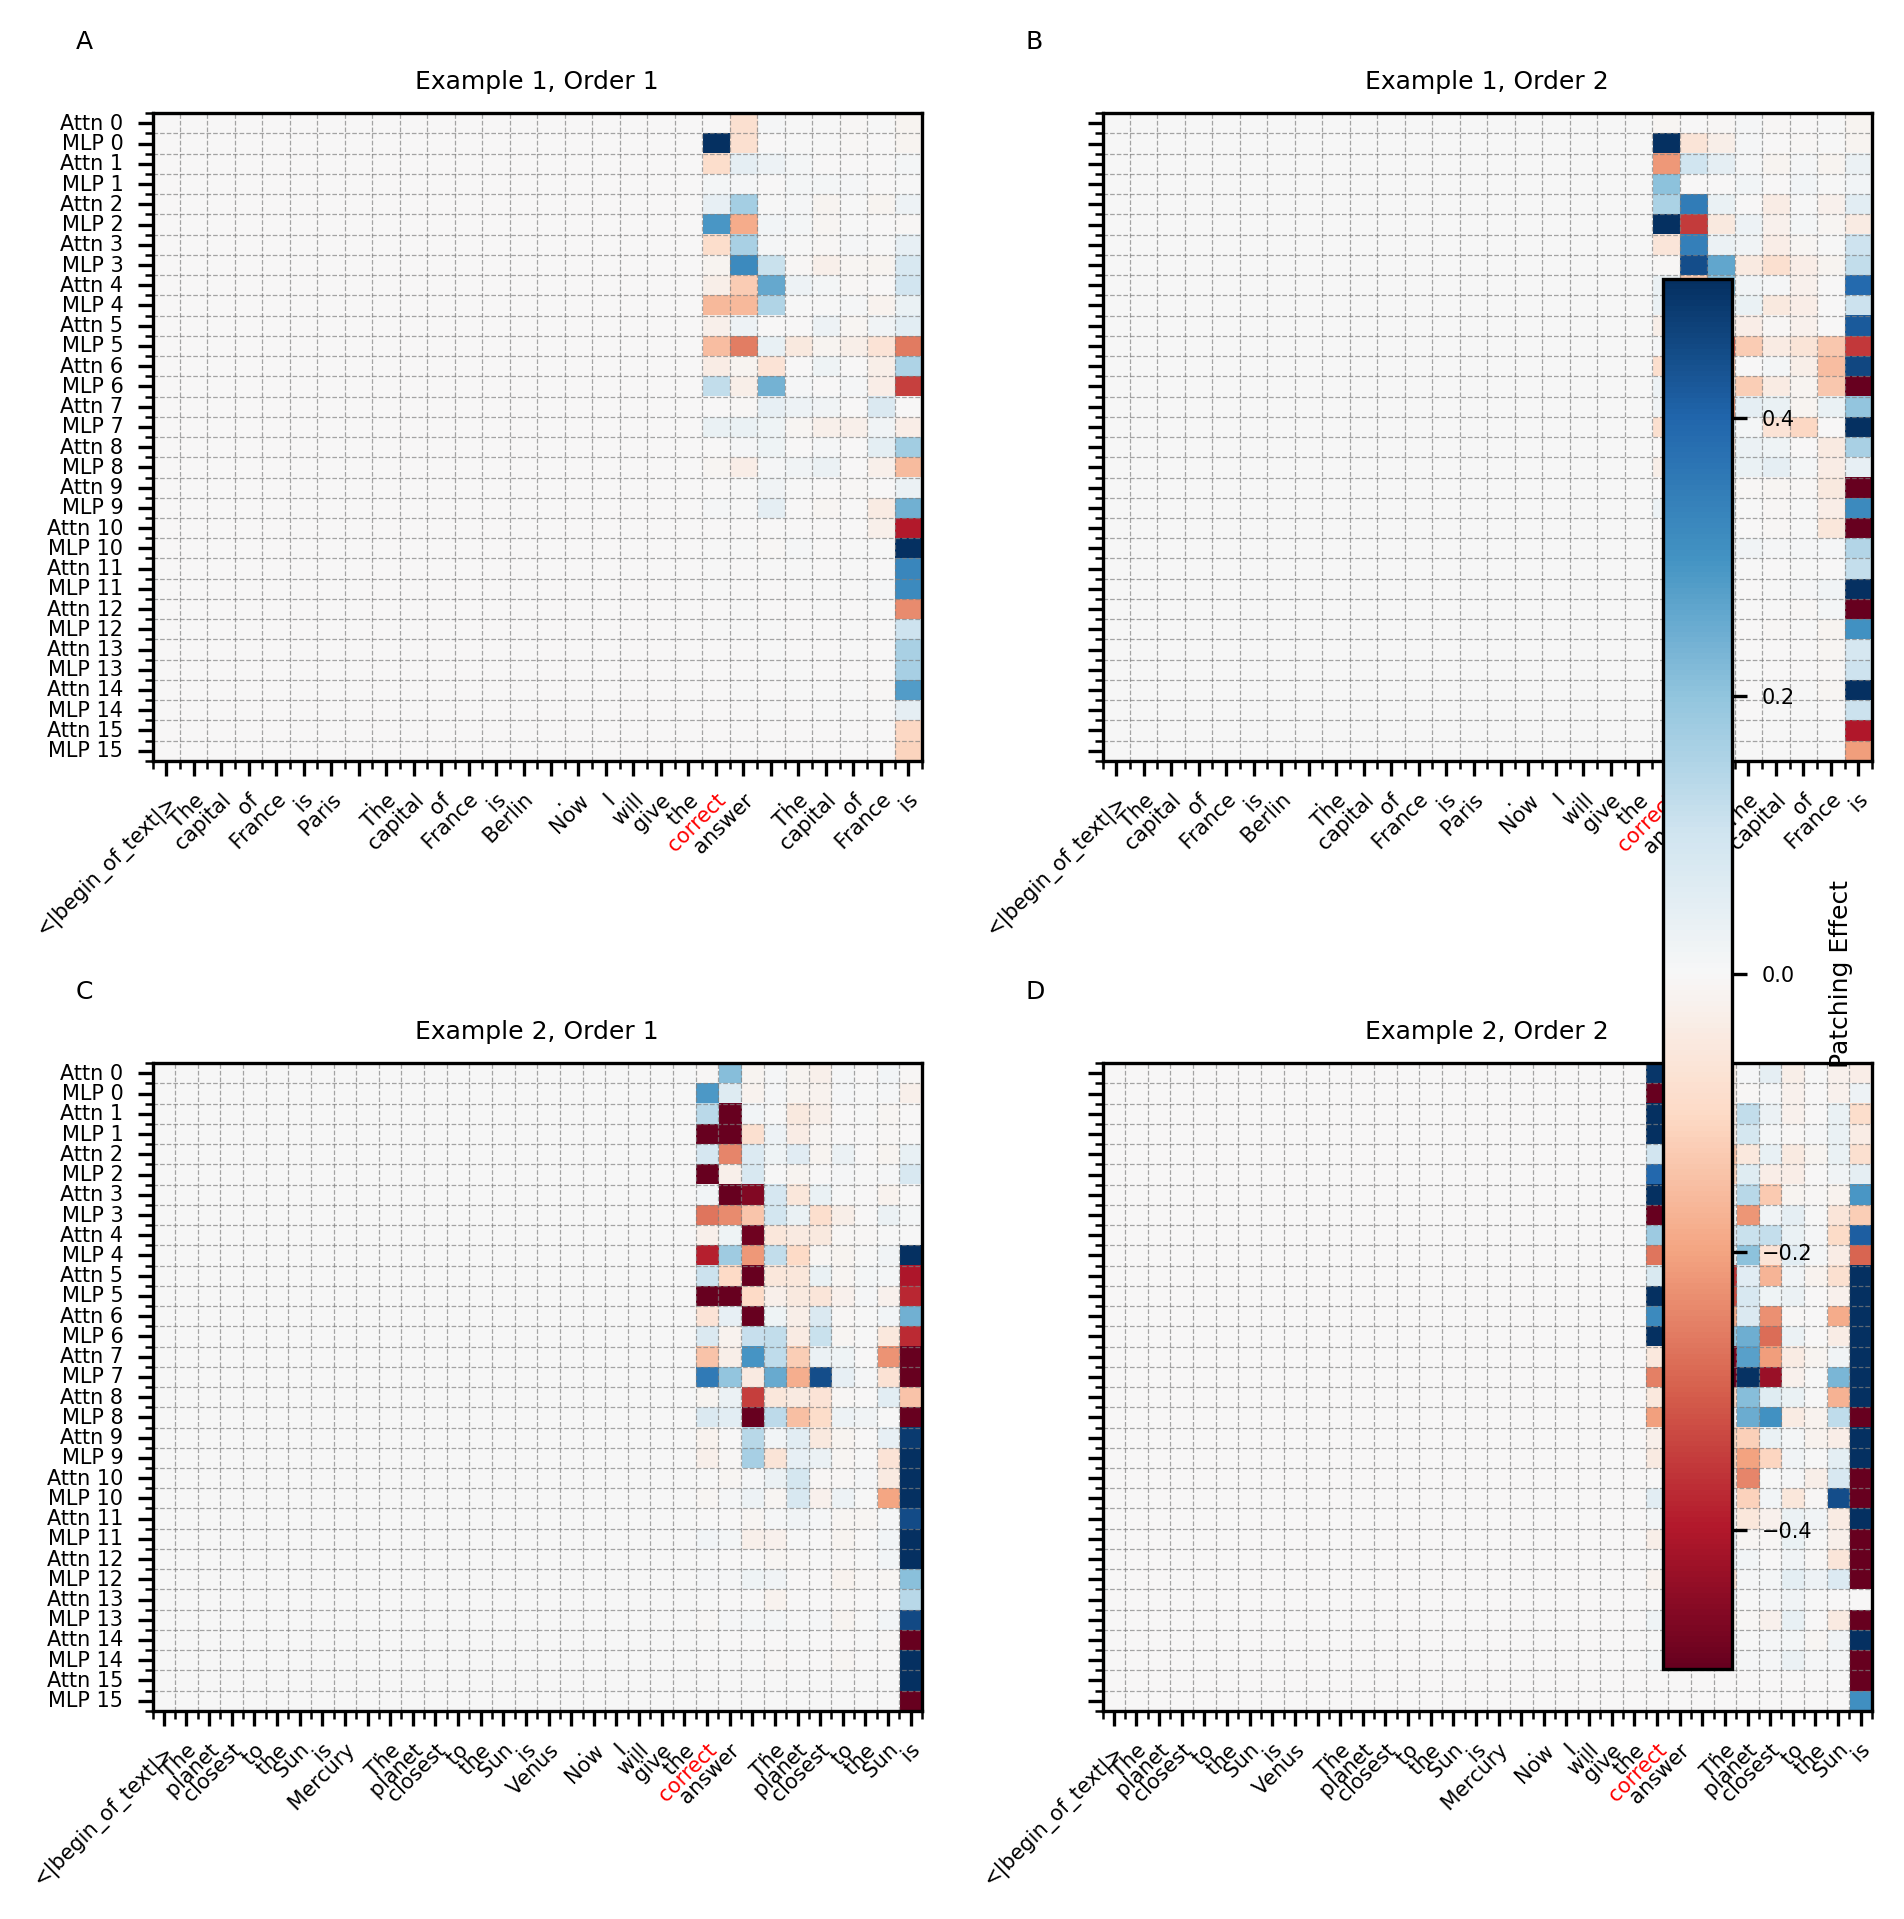

In [25]:
# plot the 2x2 heatmaps together
plot_2x2_heatmaps(patching_results1=patching_results[0][0], patching_results2=patching_results[1][0], 
                  patching_results_reversed1=patching_results_reversed[0][0], patching_results_reversed2=patching_results_reversed[1][0], 
                  clean_tokens=patching_results[0][1], clean_tokens_reversed=patching_results_reversed[0][1], 
                  clean_tokens_2=patching_results[1][1], clean_tokens_reversed_2=patching_results_reversed[1][1], 
                  prompt_row=i)

In [ ]:
plt.rcParams.keys()